<a href="https://colab.research.google.com/github/kr5red/automated-customer-reviews/blob/main/main_ki.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


# Product Review Sentiment Notebook (Classical Setup with Transformers)

This notebook is divided into different steps:

Step 1: Sentiment analysis, classifying the reviews in positive, negative and neutral through model 1: cardiffnlp/twitter-roberta-base-sentiment

1. Installs **transformers** and **pandas** dependencies.
2. Loads your CSV of reviews.
3. Merges `reviews.title` and `reviews.text` into `review_text`.
4. Light-cleans text, drops missing/duplicates.
5. Runs **cardiffnlp/twitter-roberta-base-sentiment** to get **negative/neutral/positive**.
6. Saves results to `reviews_with_sentiment.csv` and shows quick summaries.
7. Calculates accuracy.

Step 2: Product category clustering


## **STEP 1**

## 0) Install dependencies (run once)

In [ ]:
device = -1  # force CPU

In [1]:

# If running locally, uncomment the next line to install once per environment.
# You may need to restart the kernel after first install.
# %%capture
!pip install -q --upgrade pip
!pip install -q pandas numpy transformers torch tqdm


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 72.2 MB/s eta 0:00:00


## 1) Imports

In [2]:

import os
import re
import math
import pandas as pd
import numpy as np
from tqdm import tqdm

from transformers import AutoTokenizer, AutoModelForSequenceClassification, TextClassificationPipeline
import torch


## 2) Load the Dataset

In [3]:

#Set up the csv_path
import pandas as pd
from pathlib import Path
import kagglehub
pd.set_option('display.max_columns', None)

# Download all files
path = kagglehub.dataset_download("datafiniti/consumer-reviews-of-amazon-products")
csv_paths = list(Path(path).glob("*.csv"))


dfs = [pd.read_csv(p) for p in csv_paths]
df = pd.concat(dfs, ignore_index=True)

df = df.drop_duplicates(
    subset=['id', 'dateAdded', 'dateUpdated', 'reviews.text', 'reviews.title', 'reviews.username'],
    keep='first'
)

print(df.shape)
df.head()


100%|██████████| 16.3M/16.3M [00:01<00:00, 9.31MB/s]

Extracting files...


(67896, 27)


/tmp/ipython-input-1332930570.py:12: DtypeWarning: Columns (1,10) have mixed types. Specify dtype option on import or set low_memory=False.
  dfs = [pd.read_csv(p) for p in csv_paths]


,id,dateAdded,dateUpdated,name,asins,brand,categories,primaryCategories,imageURLs,keys,manufacturer,manufacturerNumber,reviews.date,reviews.dateSeen,reviews.didPurchase,reviews.doRecommend,reviews.id,reviews.numHelpful,reviews.rating,reviews.sourceURLs,reviews.text,reviews.title,reviews.username,sourceURLs,reviews.dateAdded,reviews.userCity,reviews.userProvince
0,AVpgNzjwLJeJML43Kpxn,2015-10-30T08:59:32Z,2019-04-25T09:08:16Z,AmazonBasics AAA Performance Alkaline Batterie...,"B00QWO9P0O,B00LH3DMUO",Amazonbasics,"AA,AAA,Health,Electronics,Health & Household,C...",Health & Beauty,https://images-na.ssl-images-amazon.com/images...,"amazonbasics/hl002619,amazonbasicsaaaperforman...",AmazonBasics,HL-002619,2017-03-02T00:00:00.000Z,2017-08-28T00:00:00Z,NaN,NaN,NaN,NaN,3.0,https://www.amazon.com/product-reviews/B00QWO9...,I order 3 of them and one of the item is bad q...,... 3 of them and one of the item is bad quali...,Byger yang,"https://www.barcodable.com/upc/841710106442,ht...",NaN,NaN,NaN
1,AVpgNzjwLJeJML43Kpxn,2015-10-30T08:59:32Z,2019-04-25T09:08:16Z,AmazonBasics AAA Performance Alkaline Batterie...,"B00QWO9P0O,B00LH3DMUO",Amazonbasics,"AA,AAA,Health,Electronics,Health & Household,C...",Health & Beauty,https://images-na.ssl-images-amazon.com/images...,"amazonbasics/hl002619,amazonbasicsaaaperforman...",AmazonBasics,HL-002619,2016-08-31T00:00:00.000Z,2017-08-28T00:00:00Z,NaN,NaN,NaN,NaN,4.0,https://www.amazon.com/product-reviews/B00QWO9...,Bulk is always the less expensive way to go fo...,... always the less expensive way to go for pr...,ByMG,"https://www.barcodable.com/upc/841710106442,ht...",NaN,NaN,NaN
2,AVpgNzjwLJeJML43Kpxn,2015-10-30T08:59:32Z,2019-04-25T09:08:16Z,AmazonBasics AAA Performance Alkaline Batterie...,"B00QWO9P0O,B00LH3DMUO",Amazonbasics,"AA,AAA,Health,Electronics,Health & Household,C...",Health & Beauty,https://images-na.ssl-images-amazon.com/images...,"amazonbasics/hl002619,amazonbasicsaaaperforman...",AmazonBasics,HL-002619,2016-12-06T00:00:00.000Z,2017-08-28T00:00:00Z,NaN,NaN,NaN,NaN,5.0,https://www.amazon.com/product-reviews/B00QWO9...,Well they are not Duracell but for the price i...,... are not Duracell but for the price i am ha...,BySharon Lambert,"https://www.barcodable.com/upc/841710106442,ht...",NaN,NaN,NaN
3,AVpgNzjwLJeJML43Kpxn,2015-10-30T08:59:32Z,2019-04-25T09:08:16Z,AmazonBasics AAA Performance Alkaline Batterie...,"B00QWO9P0O,B00LH3DMUO",Amazonbasics,"AA,AAA,Health,Electronics,Health & Household,C...",Health & Beauty,https://images-na.ssl-images-amazon.com/images...,"amazonbasics/hl002619,amazonbasicsaaaperforman...",AmazonBasics,HL-002619,2016-03-28T00:00:00.000Z,2017-08-28T00:00:00Z,NaN,NaN,NaN,NaN,5.0,https://www.amazon.com/product-reviews/B00QWO9...,Seem to work as well as name brand batteries a...,... as well as name brand batteries at a much ...,Bymark sexson,"https://www.barcodable.com/upc/841710106442,ht...",NaN,NaN,NaN
4,AVpgNzjwLJeJML43Kpxn,2015-10-30T08:59:32Z,2019-04-25T09:08:16Z,AmazonBasics AAA Performance Alkaline Batterie...,"B00QWO9P0O,B00LH3DMUO",Amazonbasics,"AA,AAA,Health,Electronics,Health & Household,C...",Health & Beauty,https://images-na.ssl-images-amazon.com/images...,"amazonbasics/hl002619,amazonbasicsaaaperforman...",AmazonBasics,HL-002619,2017-04-22T00:00:00.000Z,2017-08-28T00:00:00Z,NaN,NaN,NaN,NaN,5.0,https://www.amazon.com/product-reviews/B00QWO9...,These batteries are very long lasting the pric...,... batteries are very long lasting the price ...,Bylinda,"https://www.barcodable.com/upc/841710106442,ht...",NaN,NaN,NaN


## 3.1) Create unified "reviews_text" by merging title + text

In [4]:
#merge title and text
def merge_title_text(row):
    t1 = str(row.get("reviews.title") if pd.notna(row.get("reviews.title")) else "").strip()
    t2 = str(row.get("reviews.text") if pd.notna(row.get("reviews.text")) else "").strip()
    if t1 and t2:
        return f"{t1}. {t2}"
    return t1 or t2

df["review_text"] = df.apply(merge_title_text, axis=1)
df.head()

,id,dateAdded,dateUpdated,name,asins,brand,categories,primaryCategories,imageURLs,keys,manufacturer,manufacturerNumber,reviews.date,reviews.dateSeen,reviews.didPurchase,reviews.doRecommend,reviews.id,reviews.numHelpful,reviews.rating,reviews.sourceURLs,reviews.text,reviews.title,reviews.username,sourceURLs,reviews.dateAdded,reviews.userCity,reviews.userProvince,review_text
0,AVpgNzjwLJeJML43Kpxn,2015-10-30T08:59:32Z,2019-04-25T09:08:16Z,AmazonBasics AAA Performance Alkaline Batterie...,"B00QWO9P0O,B00LH3DMUO",Amazonbasics,"AA,AAA,Health,Electronics,Health & Household,C...",Health & Beauty,https://images-na.ssl-images-amazon.com/images...,"amazonbasics/hl002619,amazonbasicsaaaperforman...",AmazonBasics,HL-002619,2017-03-02T00:00:00.000Z,2017-08-28T00:00:00Z,NaN,NaN,NaN,NaN,3.0,https://www.amazon.com/product-reviews/B00QWO9...,I order 3 of them and one of the item is bad q...,... 3 of them and one of the item is bad quali...,Byger yang,"https://www.barcodable.com/upc/841710106442,ht...",NaN,NaN,NaN,... 3 of them and one of the item is bad quali...
1,AVpgNzjwLJeJML43Kpxn,2015-10-30T08:59:32Z,2019-04-25T09:08:16Z,AmazonBasics AAA Performance Alkaline Batterie...,"B00QWO9P0O,B00LH3DMUO",Amazonbasics,"AA,AAA,Health,Electronics,Health & Household,C...",Health & Beauty,https://images-na.ssl-images-amazon.com/images...,"amazonbasics/hl002619,amazonbasicsaaaperforman...",AmazonBasics,HL-002619,2016-08-31T00:00:00.000Z,2017-08-28T00:00:00Z,NaN,NaN,NaN,NaN,4.0,https://www.amazon.com/product-reviews/B00QWO9...,Bulk is always the less expensive way to go fo...,... always the less expensive way to go for pr...,ByMG,"https://www.barcodable.com/upc/841710106442,ht...",NaN,NaN,NaN,... always the less expensive way to go for pr...
2,AVpgNzjwLJeJML43Kpxn,2015-10-30T08:59:32Z,2019-04-25T09:08:16Z,AmazonBasics AAA Performance Alkaline Batterie...,"B00QWO9P0O,B00LH3DMUO",Amazonbasics,"AA,AAA,Health,Electronics,Health & Household,C...",Health & Beauty,https://images-na.ssl-images-amazon.com/images...,"amazonbasics/hl002619,amazonbasicsaaaperforman...",AmazonBasics,HL-002619,2016-12-06T00:00:00.000Z,2017-08-28T00:00:00Z,NaN,NaN,NaN,NaN,5.0,https://www.amazon.com/product-reviews/B00QWO9...,Well they are not Duracell but for the price i...,... are not Duracell but for the price i am ha...,BySharon Lambert,"https://www.barcodable.com/upc/841710106442,ht...",NaN,NaN,NaN,... are not Duracell but for the price i am ha...
3,AVpgNzjwLJeJML43Kpxn,2015-10-30T08:59:32Z,2019-04-25T09:08:16Z,AmazonBasics AAA Performance Alkaline Batterie...,"B00QWO9P0O,B00LH3DMUO",Amazonbasics,"AA,AAA,Health,Electronics,Health & Household,C...",Health & Beauty,https://images-na.ssl-images-amazon.com/images...,"amazonbasics/hl002619,amazonbasicsaaaperforman...",AmazonBasics,HL-002619,2016-03-28T00:00:00.000Z,2017-08-28T00:00:00Z,NaN,NaN,NaN,NaN,5.0,https://www.amazon.com/product-reviews/B00QWO9...,Seem to work as well as name brand batteries a...,... as well as name brand batteries at a much ...,Bymark sexson,"https://www.barcodable.com/upc/841710106442,ht...",NaN,NaN,NaN,... as well as name brand batteries at a much ...
4,AVpgNzjwLJeJML43Kpxn,2015-10-30T08:59:32Z,2019-04-25T09:08:16Z,AmazonBasics AAA Performance Alkaline Batterie...,"B00QWO9P0O,B00LH3DMUO",Amazonbasics,"AA,AAA,Health,Electronics,Health & Household,C...",Health & Beauty,https://images-na.ssl-images-amazon.com/images...,"amazonbasics/hl002619,amazonbasicsaaaperforman...",AmazonBasics,HL-002619,2017-04-22T00:00:00.000Z,2017-08-28T00:00:00Z,NaN,NaN,NaN,NaN,5.0,https://www.amazon.com/product-reviews/B00QWO9...,These batteries are very long lasting the pric...,... batteries are very long lasting the price ...,Bylinda,"https://www.barcodable.com/upc/841710106442,ht...",NaN,NaN,NaN,... batteries are very long lasting the price ...


## 3.2) Cleaning

In [5]:
# Lowercase, strip URLs/emails, collapse whitespace
def clean_text(s: str) -> str:
    s = str(s)
    s = s.lower()
    s = re.sub(r"[^\w\s'.,!?-]", " ", s)  # keep common punctuation
    s = re.sub(r"\s+", " ", s).strip()
    return s

df["review_text"].fillna("").apply(clean_text)

# Drop missing/empty
df = df[df["review_text"].str.len() > 0].copy()

# Drop exact duplicates of the clean text
before = len(df)
df = df.drop_duplicates(subset=["review_text"]).reset_index(drop=True)
after = len(df)
print(f"Dropped {before - after} duplicate rows. Remaining: {after}")
df.head()


Dropped 20576 duplicate rows. Remaining: 47320


,id,dateAdded,dateUpdated,name,asins,brand,categories,primaryCategories,imageURLs,keys,manufacturer,manufacturerNumber,reviews.date,reviews.dateSeen,reviews.didPurchase,reviews.doRecommend,reviews.id,reviews.numHelpful,reviews.rating,reviews.sourceURLs,reviews.text,reviews.title,reviews.username,sourceURLs,reviews.dateAdded,reviews.userCity,reviews.userProvince,review_text
0,AVpgNzjwLJeJML43Kpxn,2015-10-30T08:59:32Z,2019-04-25T09:08:16Z,AmazonBasics AAA Performance Alkaline Batterie...,"B00QWO9P0O,B00LH3DMUO",Amazonbasics,"AA,AAA,Health,Electronics,Health & Household,C...",Health & Beauty,https://images-na.ssl-images-amazon.com/images...,"amazonbasics/hl002619,amazonbasicsaaaperforman...",AmazonBasics,HL-002619,2017-03-02T00:00:00.000Z,2017-08-28T00:00:00Z,NaN,NaN,NaN,NaN,3.0,https://www.amazon.com/product-reviews/B00QWO9...,I order 3 of them and one of the item is bad q...,... 3 of them and one of the item is bad quali...,Byger yang,"https://www.barcodable.com/upc/841710106442,ht...",NaN,NaN,NaN,... 3 of them and one of the item is bad quali...
1,AVpgNzjwLJeJML43Kpxn,2015-10-30T08:59:32Z,2019-04-25T09:08:16Z,AmazonBasics AAA Performance Alkaline Batterie...,"B00QWO9P0O,B00LH3DMUO",Amazonbasics,"AA,AAA,Health,Electronics,Health & Household,C...",Health & Beauty,https://images-na.ssl-images-amazon.com/images...,"amazonbasics/hl002619,amazonbasicsaaaperforman...",AmazonBasics,HL-002619,2016-08-31T00:00:00.000Z,2017-08-28T00:00:00Z,NaN,NaN,NaN,NaN,4.0,https://www.amazon.com/product-reviews/B00QWO9...,Bulk is always the less expensive way to go fo...,... always the less expensive way to go for pr...,ByMG,"https://www.barcodable.com/upc/841710106442,ht...",NaN,NaN,NaN,... always the less expensive way to go for pr...
2,AVpgNzjwLJeJML43Kpxn,2015-10-30T08:59:32Z,2019-04-25T09:08:16Z,AmazonBasics AAA Performance Alkaline Batterie...,"B00QWO9P0O,B00LH3DMUO",Amazonbasics,"AA,AAA,Health,Electronics,Health & Household,C...",Health & Beauty,https://images-na.ssl-images-amazon.com/images...,"amazonbasics/hl002619,amazonbasicsaaaperforman...",AmazonBasics,HL-002619,2016-12-06T00:00:00.000Z,2017-08-28T00:00:00Z,NaN,NaN,NaN,NaN,5.0,https://www.amazon.com/product-reviews/B00QWO9...,Well they are not Duracell but for the price i...,... are not Duracell but for the price i am ha...,BySharon Lambert,"https://www.barcodable.com/upc/841710106442,ht...",NaN,NaN,NaN,... are not Duracell but for the price i am ha...
3,AVpgNzjwLJeJML43Kpxn,2015-10-30T08:59:32Z,2019-04-25T09:08:16Z,AmazonBasics AAA Performance Alkaline Batterie...,"B00QWO9P0O,B00LH3DMUO",Amazonbasics,"AA,AAA,Health,Electronics,Health & Household,C...",Health & Beauty,https://images-na.ssl-images-amazon.com/images...,"amazonbasics/hl002619,amazonbasicsaaaperforman...",AmazonBasics,HL-002619,2016-03-28T00:00:00.000Z,2017-08-28T00:00:00Z,NaN,NaN,NaN,NaN,5.0,https://www.amazon.com/product-reviews/B00QWO9...,Seem to work as well as name brand batteries a...,... as well as name brand batteries at a much ...,Bymark sexson,"https://www.barcodable.com/upc/841710106442,ht...",NaN,NaN,NaN,... as well as name brand batteries at a much ...
4,AVpgNzjwLJeJML43Kpxn,2015-10-30T08:59:32Z,2019-04-25T09:08:16Z,AmazonBasics AAA Performance Alkaline Batterie...,"B00QWO9P0O,B00LH3DMUO",Amazonbasics,"AA,AAA,Health,Electronics,Health & Household,C...",Health & Beauty,https://images-na.ssl-images-amazon.com/images...,"amazonbasics/hl002619,amazonbasicsaaaperforman...",AmazonBasics,HL-002619,2017-04-22T00:00:00.000Z,2017-08-28T00:00:00Z,NaN,NaN,NaN,NaN,5.0,https://www.amazon.com/product-reviews/B00QWO9...,These batteries are very long lasting the pric...,... batteries are very long lasting the price ...,Bylinda,"https://www.barcodable.com/upc/841710106442,ht...",NaN,NaN,NaN,... batteries are very long lasting the price ...


## 4) Load sentiment model

In [6]:

# Load chosen sentiment model: cardiffnlp/twitter-roberta-base-sentiment
from transformers import AutoTokenizer, AutoModelForSequenceClassification, pipeline
import torch

model_name = "cardiffnlp/twitter-roberta-base-sentiment"

tokenizer = AutoTokenizer.from_pretrained(model_name, use_fast=True)
model = AutoModelForSequenceClassification.from_pretrained(model_name)

# Max length safety: many RoBERTa-family models use 512 tokens (special tokens make the 514 you saw)
MAX_LEN = min(getattr(tokenizer, "model_max_length", 512), 512)

# Build id2label mapping robustly
id2label = getattr(model.config, "id2label", None)
if not id2label or not isinstance(id2label, dict) or len(id2label) < 3:
    id2label = {0: "negative", 1: "neutral", 2: "positive"}

# Use HF pipeline; we will pass truncation/padding at call time
pipe = pipeline(
    task="text-classification",
    model=model,
    tokenizer=tokenizer,
    device=0 if torch.cuda.is_available() else -1,
    return_all_scores=True
)


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/747 [00:00<?, ?B/s]

vocab.json: 0.00B [00:00, ?B/s]

merges.txt: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/150 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/499M [00:00<?, ?B/s]

Device set to use cuda:0
/usr/local/lib/python3.12/dist-packages/transformers/pipelines/text_classification.py:111: UserWarning: `return_all_scores` is now deprecated,  if want a similar functionality use `top_k=None` instead of `return_all_scores=True` or `top_k=1` instead of `return_all_scores=False`.
  warnings.warn(


## 5) Run inference in batches and collect predictions

In [7]:
from tqdm import tqdm

texts = df["review_text"].tolist()
batch_size = 16  # reduce if RAM is tight

pred_labels, pred_scores = [], []

for i in tqdm(range(0, len(texts), batch_size)):
    batch = texts[i:i+batch_size]
    # 🔑 KEY: enforce truncation/padding and a safe max_length
    outputs = pipe(batch, truncation=True, padding=True, max_length=MAX_LEN)

    for scores in outputs:
        # pick top class
        best = max(scores, key=lambda d: d["score"])
        label = best["label"].lower()
        # Normalize labels if they come as LABEL_0/1/2
        if label.startswith("label_"):
            idx = int(label.split("_")[-1])
            label = id2label.get(idx, str(idx)).lower()
        if label not in {"negative", "neutral", "positive"}:
            # fallback via rank order if labels are unexpected
            idx = scores.index(best)
            label = id2label.get(idx, "neutral").lower()

        pred_labels.append(label)
        pred_scores.append(float(best["score"]))

df["sentiment_model_labels"] = pred_labels
df["sentiment_model_confidence"] = pred_scores

  0%|          | 2/2958 [00:00<20:28,  2.41it/s]

model.safetensors:   0%|          | 0.00/499M [00:00<?, ?B/s]

100%|██████████| 2958/2958 [06:57<00:00,  7.08it/s]


In [8]:
df.head()

,id,dateAdded,dateUpdated,name,asins,brand,categories,primaryCategories,imageURLs,keys,manufacturer,manufacturerNumber,reviews.date,reviews.dateSeen,reviews.didPurchase,reviews.doRecommend,reviews.id,reviews.numHelpful,reviews.rating,reviews.sourceURLs,reviews.text,reviews.title,reviews.username,sourceURLs,reviews.dateAdded,reviews.userCity,reviews.userProvince,review_text,sentiment_model_labels,sentiment_model_confidence
0,AVpgNzjwLJeJML43Kpxn,2015-10-30T08:59:32Z,2019-04-25T09:08:16Z,AmazonBasics AAA Performance Alkaline Batterie...,"B00QWO9P0O,B00LH3DMUO",Amazonbasics,"AA,AAA,Health,Electronics,Health & Household,C...",Health & Beauty,https://images-na.ssl-images-amazon.com/images...,"amazonbasics/hl002619,amazonbasicsaaaperforman...",AmazonBasics,HL-002619,2017-03-02T00:00:00.000Z,2017-08-28T00:00:00Z,NaN,NaN,NaN,NaN,3.0,https://www.amazon.com/product-reviews/B00QWO9...,I order 3 of them and one of the item is bad q...,... 3 of them and one of the item is bad quali...,Byger yang,"https://www.barcodable.com/upc/841710106442,ht...",NaN,NaN,NaN,... 3 of them and one of the item is bad quali...,label_0,0.812543
1,AVpgNzjwLJeJML43Kpxn,2015-10-30T08:59:32Z,2019-04-25T09:08:16Z,AmazonBasics AAA Performance Alkaline Batterie...,"B00QWO9P0O,B00LH3DMUO",Amazonbasics,"AA,AAA,Health,Electronics,Health & Household,C...",Health & Beauty,https://images-na.ssl-images-amazon.com/images...,"amazonbasics/hl002619,amazonbasicsaaaperforman...",AmazonBasics,HL-002619,2016-08-31T00:00:00.000Z,2017-08-28T00:00:00Z,NaN,NaN,NaN,NaN,4.0,https://www.amazon.com/product-reviews/B00QWO9...,Bulk is always the less expensive way to go fo...,... always the less expensive way to go for pr...,ByMG,"https://www.barcodable.com/upc/841710106442,ht...",NaN,NaN,NaN,... always the less expensive way to go for pr...,label_1,0.694578
2,AVpgNzjwLJeJML43Kpxn,2015-10-30T08:59:32Z,2019-04-25T09:08:16Z,AmazonBasics AAA Performance Alkaline Batterie...,"B00QWO9P0O,B00LH3DMUO",Amazonbasics,"AA,AAA,Health,Electronics,Health & Household,C...",Health & Beauty,https://images-na.ssl-images-amazon.com/images...,"amazonbasics/hl002619,amazonbasicsaaaperforman...",AmazonBasics,HL-002619,2016-12-06T00:00:00.000Z,2017-08-28T00:00:00Z,NaN,NaN,NaN,NaN,5.0,https://www.amazon.com/product-reviews/B00QWO9...,Well they are not Duracell but for the price i...,... are not Duracell but for the price i am ha...,BySharon Lambert,"https://www.barcodable.com/upc/841710106442,ht...",NaN,NaN,NaN,... are not Duracell but for the price i am ha...,label_2,0.843387
3,AVpgNzjwLJeJML43Kpxn,2015-10-30T08:59:32Z,2019-04-25T09:08:16Z,AmazonBasics AAA Performance Alkaline Batterie...,"B00QWO9P0O,B00LH3DMUO",Amazonbasics,"AA,AAA,Health,Electronics,Health & Household,C...",Health & Beauty,https://images-na.ssl-images-amazon.com/images...,"amazonbasics/hl002619,amazonbasicsaaaperforman...",AmazonBasics,HL-002619,2016-03-28T00:00:00.000Z,2017-08-28T00:00:00Z,NaN,NaN,NaN,NaN,5.0,https://www.amazon.com/product-reviews/B00QWO9...,Seem to work as well as name brand batteries a...,... as well as name brand batteries at a much ...,Bymark sexson,"https://www.barcodable.com/upc/841710106442,ht...",NaN,NaN,NaN,... as well as name brand batteries at a much ...,label_2,0.890323
4,AVpgNzjwLJeJML43Kpxn,2015-10-30T08:59:32Z,2019-04-25T09:08:16Z,AmazonBasics AAA Performance Alkaline Batterie...,"B00QWO9P0O,B00LH3DMUO",Amazonbasics,"AA,AAA,Health,Electronics,Health & Household,C...",Health & Beauty,https://images-na.ssl-images-amazon.com/images...,"amazonbasics/hl002619,amazonbasicsaaaperforman...",AmazonBasics,HL-002619,2017-04-22T00:00:00.000Z,2017-08-28T00:00:00Z,NaN,NaN,NaN,NaN,5.0,https://www.amazon.com/product-reviews/B00QWO9...,These batteries are very long lasting the pric...,... batteries are very long lasting the price ...,Bylinda,"https://www.barcodable.com/upc/841710106442,ht...",NaN,NaN,NaN,... batteries are very long lasting the price ...,label_2,0.937620


## 6) Save results

In [9]:

out_path = "reviews_with_sentiment_model.csv"
df.to_csv(out_path, index=False)
out_path, df.shape


('reviews_with_sentiment_model.csv', (47320, 30))

## 7) Quick summary & sanity checks

In [10]:

print(df["sentiment_model_labels"].value_counts(dropna=False))
df.sample(5, random_state=42)[["reviews.title", "reviews.text", "review_text", "sentiment_model_labels", "sentiment_model_confidence"]]



sentiment_model_labels
label_2    42955
label_0     2485
label_1     1880
Name: count, dtype: int64


,reviews.title,reviews.text,review_text,sentiment_model_labels,sentiment_model_confidence
8790,I got a charge out of this one !,Fantastic value for a great quality battery !,I got a charge out of this one !. Fantastic va...,label_2,0.975307
16840,Great kids,"Decent tablet, bought as a gift. My niece was ...","Great kids. Decent tablet, bought as a gift. M...",label_2,0.989113
29906,good tablet for readers,"thin and excellent design!most of all, the Ama...",good tablet for readers. thin and excellent de...,label_2,0.987543
25565,Great tablet for a 2 year old,My God Daughter loves it it's just next time I...,Great tablet for a 2 year old. My God Daughter...,label_2,0.973784
42618,best product in its class at the moment,"Excellent performance, Alexa really performs, ...",best product in its class at the moment. Excel...,label_2,0.976523


### 8) Classification

In [11]:

# Map ratings (1–5) to sentiment
def sentiment_through_rating(r):
    if r <= 2:
        return "negative"
    elif r == 3:
        return "neutral"
    else:
        return "positive"

df["sentiment_ratings_true"] = df["reviews.rating"].apply(sentiment_through_rating)

def sentiment_through_model(r):
    if r == "label_02":
        return "postive"
    elif r == "label_01":
        return "neutral"
    else:
        return "positive"

df["sentiment_model"] = df["sentiment_model_labels"].apply(sentiment_through_model)

#   id2label = {0: "negative", 1: "neutral", 2: "positive"}
df.sample(5, random_state=42)[["reviews.rating" , "reviews.title", "reviews.text", "review_text", "sentiment_model_labels", "sentiment_model_confidence", "sentiment_model", "sentiment_ratings_true"]]

,reviews.rating,reviews.title,reviews.text,review_text,sentiment_model_labels,sentiment_model_confidence,sentiment_model,sentiment_ratings_true
8790,5.0,I got a charge out of this one !,Fantastic value for a great quality battery !,I got a charge out of this one !. Fantastic va...,label_2,0.975307,positive,positive
16840,4.0,Great kids,"Decent tablet, bought as a gift. My niece was ...","Great kids. Decent tablet, bought as a gift. M...",label_2,0.989113,positive,positive
29906,5.0,good tablet for readers,"thin and excellent design!most of all, the Ama...",good tablet for readers. thin and excellent de...,label_2,0.987543,positive,positive
25565,3.0,Great tablet for a 2 year old,My God Daughter loves it it's just next time I...,Great tablet for a 2 year old. My God Daughter...,label_2,0.973784,positive,neutral
42618,5.0,best product in its class at the moment,"Excellent performance, Alexa really performs, ...",best product in its class at the moment. Excel...,label_2,0.976523,positive,positive


## 9) Accuracy score

In [12]:
from sklearn.metrics import accuracy_score, classification_report

# Convert to string and handle missing values
y_true = df['sentiment_ratings_true'].astype(str)
y_pred = df['sentiment_model'].astype(str)

acc_score = accuracy_score(y_true, y_pred)
print(f"Accuracy Score: {acc_score:.4f}")


Accuracy Score: 0.9172


## **STEP 2:**

## 1) Imports

In [13]:
from sentence_transformers import SentenceTransformer
from sklearn.cluster import KMeans

out_path = "reviews_with_sentiment.csv"
df.to_csv(out_path, index=False)
out_path, df.shape
print(df.shape)

(47320, 32)


## 2) Clean up product names


In [14]:
# Drop empties and duplicates
df = df[df["name"].str.strip().astype(bool)]
df = df.drop_duplicates(subset=["name"]).reset_index(drop=True)

print("Unique products:", len(df))
df["name"].head(3)

Unique products: 113


,name
0,AmazonBasics AAA Performance Alkaline Batterie...
1,AmazonBasics Nylon CD/DVD Binder (400 Capacity)
2,Amazon Echo ‚Äì White


In [16]:
import re

def clean_product_name(s: str) -> str:
    s = str(s).lower()
    s = re.sub(r"[^a-z0-9 ]", " ", s)        # keep alphanumeric only
    s = re.sub(r"\s+", " ", s).strip()
    # Remove overly common brand names or filler words
    for stop in ["amazon", "fire", "kindle", "echo", "new", "all", "thgeneration"]:
        s = s.replace(stop, "")
    return s.strip()

df["product_clean"] = df["name"].fillna("").apply(clean_product_name)
df["product_clean"].head(3)

,product_clean
0,basics aaa performance alkaline batteries 36 c...
1,basics nylon cd dvd binder 400 capacity
2,white


## 2) Load SentenceTransformer model to create text embeddings


In [17]:
model_emb = SentenceTransformer("sentence-transformers/all-MiniLM-L6-v2")

embeddings = model_emb.encode(
    df["product_clean"].tolist(),
    batch_size=32,
    show_progress_bar=True
)
print("Embeddings shape:", embeddings.shape)



modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md: 0.00B [00:00, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/612 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/350 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

Batches:   0%|          | 0/4 [00:00<?, ?it/s]

Embeddings shape: (113, 384)


## 3) Find out how many clusters

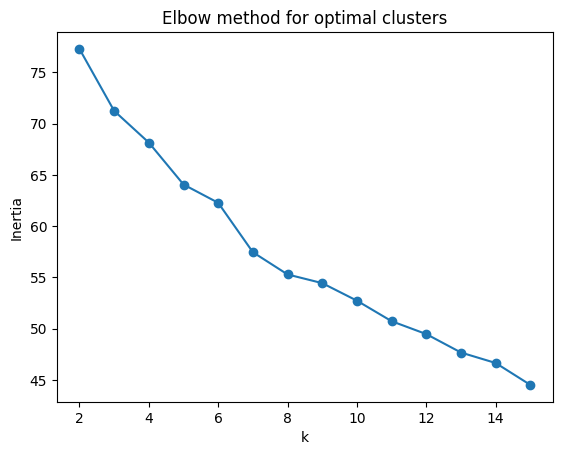

In [18]:
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans

# Try a few cluster counts
inertias = []
K = range(2, 16)
for k in K:
    km = KMeans(n_clusters=k, random_state=42, n_init="auto").fit(embeddings)
    inertias.append(km.inertia_)

plt.plot(K, inertias, marker="o")
plt.xlabel("k")
plt.ylabel("Inertia")
plt.title("Elbow method for optimal clusters")
plt.show()


## 4) Clustering based on elbow method (plot)

In [19]:
n_clusters = 10
km = KMeans(n_clusters=n_clusters, random_state=42, n_init="auto")
df["product_cluster"] = km.fit_predict(embeddings)

for i in range(n_clusters):
    print(f"\n--- Cluster {i} ---")
    sample = df[df["product_cluster"] == i].head(5)
    for s in sample["product_clean"]:
        print("-", s)


--- Cluster 0 ---
- tap smart assistant alexaenabled black brand
- 7 tablet with alexa 7 display 8 gb marine blue
- hd 8 with alexa 8 hd display tablet
- hd 8 tablet with alexa 8 hd display 16 gb marine blue with special offers
- hd 8 tablet with alexa 8 hd display 32 gb marine blue with special offers

--- Cluster 1 ---
- e reader black 6 glare free touchscreen display wi fi includes special offers
- voyage e reader 6 high resolution display 300 ppi with adaptive built in light pagepress sensors wi fi includes special offers
- oasis e reader with leather charging cover black 6 high resolution display 300 ppi wi fi includes special offers
- voyage e reader 6 high resolution display 300 ppi with adaptive built in light pagepress sensors free 3g wi fi includes special offers
- oasis e reader with leather charging cover merlot 6 high resolution display 300 ppi wi fi includes special offers

--- Cluster 2 ---
- basics aaa performance alkaline batteries 36 count
- basics aa performance alk

In [20]:
#check how many products each cluster has
df["product_cluster"].value_counts().sort_index()

,count
product_cluster,
0,16
1,18
2,14
3,19
4,5
5,6
6,9
7,2
8,20


## 5) Define cluster labels and inspect them

In [21]:
#cluster labels based on top words
from collections import Counter
import re

def top_words(texts, n=5):
    words = " ".join(texts).lower()
    words = re.findall(r"[a-z]{3,}", words)
    return [w for w, _ in Counter(words).most_common(n)]

cluster_labels = {}
for i in range(n_clusters):
    subset = df.loc[df["product_cluster"] == i, "product_clean"].tolist()
    cluster_labels[i] = ", ".join(top_words(subset))

df["cluster_label"] = df["product_cluster"].map(cluster_labels)

In [22]:
for i, label in cluster_labels.items():
    print(f"Cluster {i}: {label}")

Cluster 0: with, alexa, tablet, display, special
Cluster 1: reader, display, includes, special, offers
Cluster 2: usb, and, charger, adapter, power
Cluster 3: tablet, display, special, offers, includes
Cluster 4: door, crate, dog, basics, cat
Cluster 5: case, kids, edition, tablet, display
Cluster 6: basics, laptop, inch, male, feet
Cluster 7: paperwhite, generation, with, improved, sound
Cluster 8: black, white, generation, keyboard, certified
Cluster 9: generation, standing, protective, case, black


/usr/local/lib/python3.12/dist-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


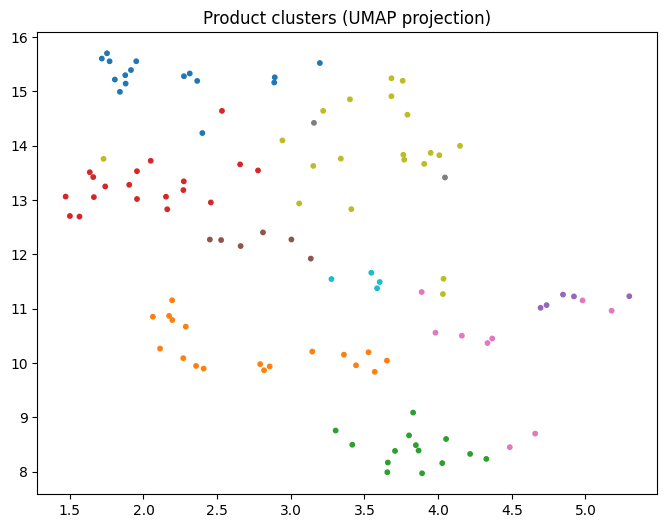

In [23]:
!pip install umap-learn matplotlib

import umap.umap_ as umap
import matplotlib.pyplot as plt

reducer = umap.UMAP(random_state=42)
emb_2d = reducer.fit_transform(embeddings)

plt.figure(figsize=(8,6))
plt.scatter(emb_2d[:,0], emb_2d[:,1], c=df["product_cluster"], cmap="tab10", s=10)
plt.title("Product clusters (UMAP projection)")
plt.show()